In [209]:
from pymongo import MongoClient
from web.mongo_remote_password import user, password

ip = '142.93.63.241'

client = MongoClient(f'mongodb://{user}:{password}@{ip}:27017')
db = client.twitter_news

Exploracion de datos de http://news-topic-labeling.gq/

In [210]:
from pprint import pprint
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np

from bson.objectid import ObjectId

%matplotlib inline

Cantidad de tweets etiquetados con 3, 2 y 1 label:

In [211]:
# 4/10/18
# 439
# 523
# 646

# 16/10/18
# 458
# 574
# 706

with_3 = list(db.representatives.find({'topic.2': {"$exists": True}}))
with_2 = list(db.representatives.find({'topic.1': {"$exists": True}}))
with_1 = list(db.representatives.find({'topic.0': {"$exists": True}}))

print(len(with_3))
print(len(with_2))
print(len(with_1))

458
574
706


Conteo de etiquetas por usuario:

In [5]:
users = Counter()
for eval_ in with_1:
    topic = eval_.get('topic')
    for label in topic:
        user = label.get('user_name')
        users.update({user: 1})

pprint(sorted(users.items(), key=lambda x: x[0]))

[('user_0', 2),
 ('user_1', 11),
 ('user_10', 346),
 ('user_11', 206),
 ('user_12', 32),
 ('user_13', 75),
 ('user_14', 101),
 ('user_15', 325),
 ('user_2', 101),
 ('user_3', 39),
 ('user_4', 31),
 ('user_5', 128),
 ('user_6', 154),
 ('user_7', 81),
 ('user_8', 107)]


In [6]:
events = db.events.find()
events = list(events)
event_ids = [event['_id'] for event in events]
print(event_ids)

[ObjectId('5b171725da870923dcb0478f'), ObjectId('5b171726da870923dcb04790'), ObjectId('5b171726da870923dcb04791')]


In [7]:
pprint(with_3[0])

{'_id': ObjectId('5b171726da870923dcb04970'),
 'event': ObjectId('5b171725da870923dcb0478f'),
 'predef_topic': '5b184122da870950572be266',
 'ranking': 47,
 'topic': [{'added_timestamp': datetime.datetime(2018, 8, 24, 18, 11, 39, 144000),
            'info': {'skipped': True},
            'user_name': 'user_15'},
           {'added_timestamp': datetime.datetime(2018, 9, 10, 18, 53, 4, 860000),
            'info': {'custom_topic': 'Initial information of the attack'},
            'user_name': 'user_2'},
           {'added_timestamp': datetime.datetime(2018, 9, 26, 21, 36, 26, 895000),
            'info': {'non_relevant': True},
            'user_name': 'user_10'}]}


In [8]:
# consenso

# pprint(with_3[0])
consensos = defaultdict(list)

for rep in with_3:
    labels = Counter()
    for label in rep['topic']:
        info = label['info']
        topics = info.get('topics', [])
        for t in topics:
            labels[t] += 1
    if labels:
        c = max(v / sum(labels.values()) for v in labels.values())
        consensos[rep['event']].append(c)
    else:
        consensos[rep['event']].append(0)

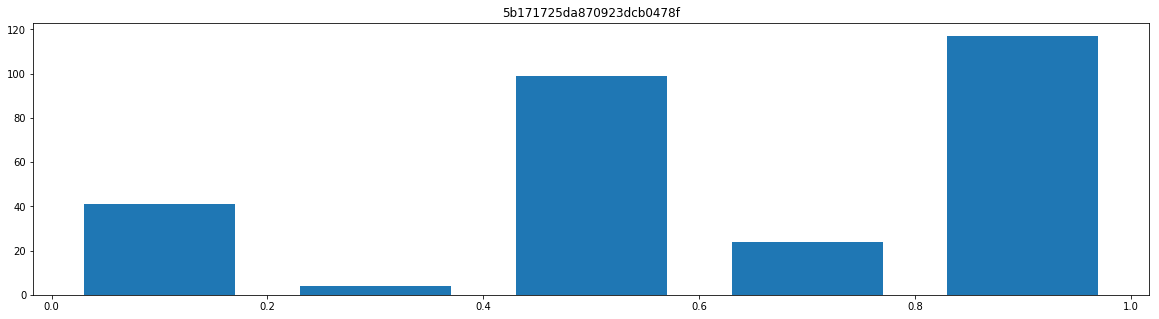

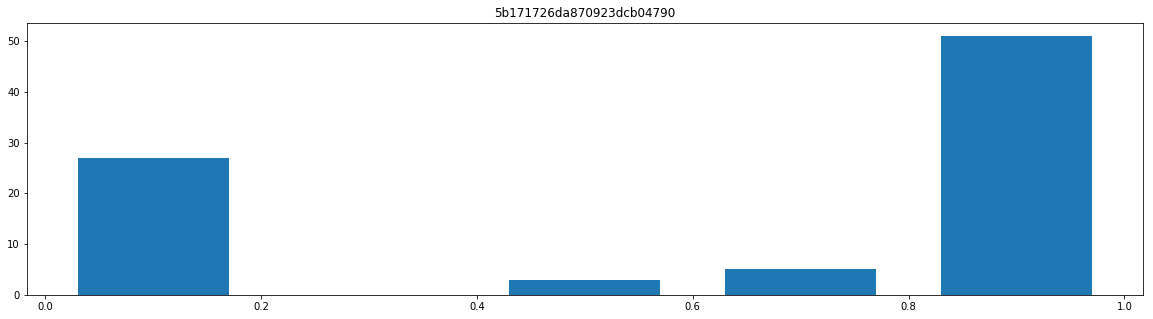

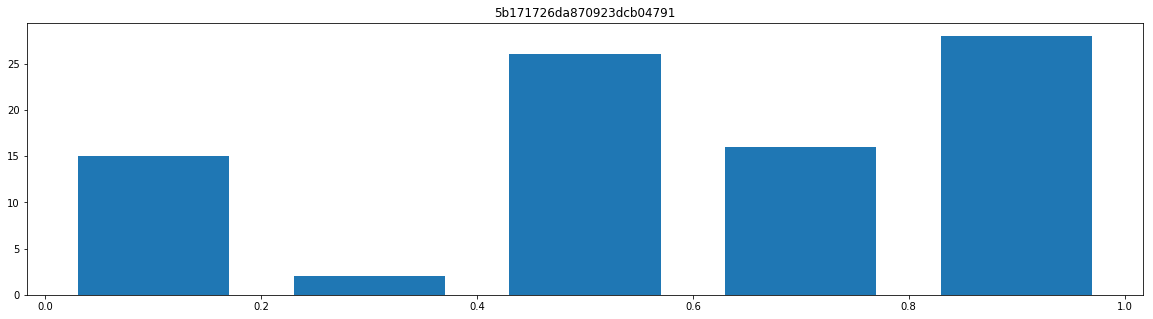

In [9]:
for event_id in event_ids:
    hist, bins = np.histogram(consensos[event_id], bins=5)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2

    plt.figure(figsize=(20, 5))
    plt.bar(center, hist, align='center', width=width)

    #plt.xticks(np.arange(0, max(consensos)+251, 250))
    plt.title(str(event_id))
    plt.show()

In [10]:
types = defaultdict(lambda: Counter())
for rep in with_1:
    topic = rep.get('topic')
    for entry in topic:
        info = entry.get('info')
        for key in info.keys():
            types[rep['event']][key] += 1

for event_id in event_ids:
    print(event_id)
    print("total types", sum(types[event_id].values()))
    print("types:", list(types[event_id].most_common()))
    print()

5b171725da870923dcb0478f
total types 998
types: [('topics', 742), ('non_relevant', 132), ('custom_topic', 84), ('skipped', 40)]

5b171726da870923dcb04790
total types 358
types: [('topics', 210), ('non_relevant', 108), ('skipped', 32), ('custom_topic', 8)]

5b171726da870923dcb04791
total types 427
types: [('topics', 283), ('non_relevant', 101), ('skipped', 35), ('custom_topic', 8)]



In [11]:
rep

{'_id': ObjectId('5b1717a9da870923dcbd90e9'),
 'event': ObjectId('5b171726da870923dcb04791'),
 'predef_topic': '5b19af02da87097532fd0483',
 'ranking': 15,
 'topic': [{'info': {'non_relevant': True},
   'added_timestamp': datetime.datetime(2018, 8, 24, 19, 38, 36, 545000),
   'user_name': 'user_15'},
  {'info': {'topics': [ObjectId('5b19af0cda87097532fd0484')]},
   'added_timestamp': datetime.datetime(2018, 9, 29, 15, 47, 27, 532000),
   'user_name': 'user_10'}]}

In [12]:
list(db.events.find())

[{'_id': ObjectId('5b171725da870923dcb0478f'),
  'event_name': 'libya_hotel_tweets.tsv',
  'description': 'In January 2015, the Corinthia Hotel in Tripoli was attacked by men affiliated with the Islamic State of Iraq and the Levant (ISIL). The hotel was popular with foreign officials and government workers; it had previously housed the Libyan Prime Minister.',
  'human_name': '2015 Corinthia Hotel attack',
  'url': 'https://en.wikipedia.org/wiki/2015_Corinthia_Hotel_attack'},
 {'_id': ObjectId('5b171726da870923dcb04790'),
  'event_name': 'oscar_pistorius_tweets.tsv',
  'description': 'The trial of Oscar Pistorius for the murder of Reeva Steenkamp and several gun-related charges (The State vs Oscar Pistorius) in the High Court of South Africa in Pretoria opened on 3 March 2014.',
  'human_name': 'Trial of Oscar Pistorius',
  'url': 'https://en.wikipedia.org/wiki/Trial_of_Oscar_Pistorius'},
 {'_id': ObjectId('5b171726da870923dcb04791'),
  'event_name': 'nepal_tweets.tsv',
  'description'

# Evento 1: Libya hotel

In [13]:
libya = ObjectId('5b171725da870923dcb0478f')

In [14]:
list(db.topics.find({'event': libya}, {'topic_name': True}))

[{'_id': ObjectId('5b18410fda870950572be265'),
  'topic_name': 'Car bomb explodes'},
 {'_id': ObjectId('5b184122da870950572be266'),
  'topic_name': 'ISIS adjudicates attack'},
 {'_id': ObjectId('5b18412bda870950572be267'),
  'topic_name': 'Report on the amount of casualties'},
 {'_id': ObjectId('5b184131da870950572be268'),
  'topic_name': 'Hostages are taken'},
 {'_id': ObjectId('5b18413eda870950572be269'),
  'topic_name': 'Report on the number of attackers'},
 {'_id': ObjectId('5b18415bda870950572be26a'),
  'topic_name': 'Confrontation with security forces'},
 {'_id': ObjectId('5b18415dda870950572be26b'), 'topic_name': 'Non relevant'}]

In [15]:
reps = db.representatives.find({'event': libya, 'topic.0': {'$exists': True}})
reps_l = list(reps)

print("total", len(reps_l))

total 352


In [16]:
with open('topic_labeling_results/libya.tsv', 'w') as f:
    f.write(f'rep_id\teval\tuser\tdate\ttype\tlabel\n')
    for rep in reps_l:
        topic_ = rep.get('topic')
        rep_id = rep['_id']

        for i, t in enumerate(topic_):
            info = t['info']
            eval_no = i + 1
            user_name = t['user_name']
            date = t['added_timestamp'].strftime('%Y-%m-%d %H:%M:%S')
            for key, val in info.items():
                if key == 'topics':
                    for t_id in val:
                        f.write(f"{rep_id}\t{eval_no}\t{user_name}\t{date}\ttopic\t{str(t_id)}\n")
                elif key == 'custom_topic':
                    f.write(f'{rep_id}\t{eval_no}\t{user_name}\t{date}\tcustom\t"{val}"\n')
                elif key == 'skipped':
                    f.write(f"{rep_id}\t{eval_no}\t{user_name}\t{date}\tskipped\tskipped\n")
                elif key == 'non_relevant':
                    f.write(f"{rep_id}\t{eval_no}\t{user_name}\t{date}\tnon_relevant\tnon_relevant\n")

In [17]:
db.tweets.find_one()

{'_id': ObjectId('5b171726da870923dcb04793'),
 'tweet_id': 560029596029292544,
 'text': 'Gunmen possibly linked to Islamic State attack hotel popular with foreigners in Libyan capital Tripoli -officials http://t.co/dNG1ykqJi0',
 'created_at': datetime.datetime(2015, 1, 27, 11, 0, 35),
 'retweet_id': 560025454057619456,
 'reply_id': None,
 'short_urls': ['http://t.co/dNG1ykqJi0'],
 'expanded_urls': ['http://www.bbc.co.uk/news/world-africa-31001094'],
 'representative': ObjectId('5b171726da870923dcb04792')}

In [18]:
# falla

%%time

from tqdm import tqdm

reps = db.representatives.find({'event': libya})
all_tweets = list(db.tweets.find())

tweets_rep = defaultdict(list)
for t in all_tweets:
    tweets_rep[str(t['representative'])].append(t)

with open('topic_labeling_results/libya_repr_mapping.tsv', 'w') as f:
    for r in tqdm(reps):
        tweets = tweets_rep[str(r['_id'])]
        for t in tweets:
            f.write(f"{str(r['_id'])}\t{str(t['tweet_id'])}\n")
    


KeyboardInterrupt: 

#  imputacion de clases para entropia

In [24]:
topic_counts = Counter()

for rep in reps_l:
    topic_ = rep.get('topic')
    rep_id = rep['_id']

    for i, t in enumerate(topic_):
        info = t['info']
        eval_no = i + 1
        user_name = t['user_name']
        date = t['added_timestamp'].strftime('%Y-%m-%d %H:%M:%S')
        
        for key, val in info.items():
            if key == 'topics':
                for t_id in val:
                    topic_counts[t_id] += 1
            elif key == 'custom_topic':
                topic_counts[val] += 1

topic_counts.most_common()

[(ObjectId('5b18412bda870950572be267'), 414),
 (ObjectId('5b184131da870950572be268'), 284),
 (ObjectId('5b18410fda870950572be265'), 181),
 (ObjectId('5b18415bda870950572be26a'), 128),
 (ObjectId('5b184122da870950572be266'), 59),
 ('Attackers are gunmen', 28),
 (ObjectId('5b18413eda870950572be269'), 17),
 ('Report on who are the attackers', 6),
 ('Related to official interviews', 6),
 ('Context about attack', 6),
 ('Attackers information', 4),
 ('Attackers linked to ISIS', 3),
 ('General information', 3),
 ('Report of the attack', 3),
 ('Terrorist attack', 3),
 ('attackers are killed', 2),
 ('Initial information of the attack', 1),
 ('gunmen attack', 1),
 ("attackers' equipment", 1),
 ('Identification of responsable', 1),
 ('Attackers blow themselves up', 1),
 ('Gunmen blow themselves up', 1),
 ('Suicide of the attackers', 1),
 ('Related to a threat sent previous the attack', 1),
 ('images of explosion', 1),
 ('terrorism attack', 1),
 ('location of terrorists inside the hotel', 1),
 ('C

# Asociar rep al topico mas frecuente

In [34]:
topics_ranked = [t for (t, _) in topic_counts.most_common()]
rep_class = dict()

for rep in reps_l:
    topic_ = rep.get('topic')
    rep_id = rep['_id']

    for topic_r in topics_ranked:
        topic_found = False
        
        # evals of this rep
        for i, t in enumerate(topic_):
            info = t['info']
            
            for key, val in info.items():
                if key == 'topics':
                    for t_id in val:
                        if t_id == topic_r:
                            rep_class[str(rep_id)] = str(t_id)
                            topic_found = True
                            break
                
                elif key == 'custom_topic':
                    if key == topic_r:
                        rep_class[str(rep_id)] = key
                        topic_found = True
                        break
                
                if topic_found:
                    break
                    
            if topic_found:
                break
                
        if topic_found:
            break

In [35]:
rep_class

{'5b171726da870923dcb049a2': '5b184131da870950572be268',
 '5b171726da870923dcb04a9a': '5b18412bda870950572be267',
 '5b171726da870923dcb04bf9': '5b18415bda870950572be26a',
 '5b171726da870923dcb04bfd': '5b18415bda870950572be26a',
 '5b171726da870923dcb04c0a': '5b18412bda870950572be267',
 '5b171726da870923dcb04c2a': '5b18412bda870950572be267',
 '5b171726da870923dcb04df6': '5b184122da870950572be266',
 '5b171727da870923dcb04e82': '5b184131da870950572be268',
 '5b171727da870923dcb04fd3': '5b18412bda870950572be267',
 '5b171727da870923dcb05087': '5b18412bda870950572be267',
 '5b171727da870923dcb050e7': '5b18412bda870950572be267',
 '5b171727da870923dcb050f3': '5b18412bda870950572be267',
 '5b171727da870923dcb05161': '5b18412bda870950572be267',
 '5b171727da870923dcb0517e': '5b18412bda870950572be267',
 '5b171727da870923dcb051e6': '5b18412bda870950572be267',
 '5b171727da870923dcb051ed': '5b18412bda870950572be267',
 '5b171727da870923dcb05214': '5b18412bda870950572be267',
 '5b171727da870923dcb05232': '5

# Cargar mapping rep_id => tweet_id

In [53]:
from collections import defaultdict
rep_map = defaultdict(list)

with open('topic_labeling_results/libya_repr_mapping.tsv', 'r') as f:
    for line in f:
        rep_id, tweet_id = line[:-1].split('\t')
        rep_map[rep_id].append(tweet_id)

In [54]:
rep_map

defaultdict(list,
            {'5b171726da870923dcb04792': ['560029596029292544',
              '560025454057619456',
              '560029586122354688',
              '560029575078375424',
              '560029491360436224',
              '560029466676961280',
              '560029444988223488',
              '560029390998757376',
              '560029198728048640',
              '560029166880296961',
              '560029115496280065',
              '560029057291522050',
              '560028825615364096',
              '560028825380474880',
              '560028759630569472',
              '560028692454572032',
              '560028685680803840',
              '560028623433134081',
              '560028494424317952',
              '560028468751380480',
              '560028325314580480',
              '560028319333511168',
              '560028280586518528',
              '560028130078113793',
              '560027946900262912',
              '560027876041719810',
              '560

# Generar modelo

In [38]:
from gensim.models import KeyedVectors
from pathlib import Path
import json
import spacy
from gen_model import gen_model

nlp = spacy.load('en', disable=["tagger", "parser", "ner"])

uf, event_data = gen_model('libya_hotel_tweets.tsv')
we = KeyedVectors.load_word2vec_format('/home/mquezada/anchor-text-twitter/data/ft_alltweets_model.vec')

2018-10-18 11:51:46,551 : loading short urls
2018-10-18 11:51:56,350 : loaded 1532034 urls
2018-10-18 11:51:56,350 : loading expanded urls
2018-10-18 11:52:04,151 : loaded 2214565 urls
2018-10-18 11:52:04,151 : cleaning url residual info
2018-10-18 11:52:05,264 : load and clean dataset: libya_hotel_tweets.tsv
2018-10-18 11:52:05,422 : tweets processed: 26331, ignored: 2309, missing urls: 6341
2018-10-18 11:52:05,423 : create pairs (t, u) or (t, t') for each tweet t and url u or replied/retweeted tweet t'
2018-10-18 11:52:05,443 : total pairs: 20108, retweets: 11323, quotes: 0, replies: 289 (missing: 0)
2018-10-18 11:52:05,444 : applying union-find
2018-10-18 11:52:05,580 : total components: 2747
2018-10-18 11:52:05,581 : loading projection weights from /home/mquezada/anchor-text-twitter/data/ft_alltweets_model.vec
2018-10-18 11:53:08,260 : loaded (1076139, 100) matrix from /home/mquezada/anchor-text-twitter/data/ft_alltweets_model.vec


In [39]:
from collections import defaultdict
from tqdm import tqdm

docs = defaultdict(list)
docs_twids = defaultdict(list)

for c in tqdm(uf.components()):
    keys = []
    texts = []
    ids = []
    for e in c:
        if e.startswith('http'):
            keys.append(e)
        else:
            t = event_data[e]
            texts.append(t.text)
            ids.append(t.tweet_id)
            
    docs[tuple(keys)] = texts
    docs_twids[tuple(keys)] = ids

100%|██████████| 2747/2747 [00:00<00:00, 119085.43it/s]


In [90]:
import numpy as np

vec_docs_idx = list()
vecs = dict()

for j, (doc, texts) in enumerate(docs.items()):    
    doc_vecs = []
    for text in nlp.pipe(texts, n_threads=8):
        text_vec = [we[token.lower_] for token in text if not token.like_url and token.lower_ in we]
        doc_vecs.extend(text_vec)
        
    if len(doc_vecs) > 0:
        avg_vec = np.array(doc_vecs).mean(axis=0)
        vecs[doc] = avg_vec
        vec_docs_idx.append(j)

In [61]:
tw_class = dict()
for rep_id, topic_id in rep_class.items():
    tw_ids = rep_map[rep_id]
    
    for tw_id in tw_ids:            
        tw_class[tw_id] = topic_id

In [74]:
for key in docs.keys():
    id_ = docs_twids.get(key)
    print(len(id_))
    for i_ in id_:
        if i_ in tw_class:
            print(tw_class[i_])

1
1
6351
5b18410fda870950572be265
5b18410fda870950572be265
5b18410fda870950572be265
5b18410fda870950572be265
5b18412bda870950572be267
5b184131da870950572be268
5b18412bda870950572be267
5b18410fda870950572be265
5b18412bda870950572be267
5b184122da870950572be266
5b18412bda870950572be267
5b184131da870950572be268
5b184131da870950572be268
5b18412bda870950572be267
5b18412bda870950572be267
5b18410fda870950572be265
5b18412bda870950572be267
5b184122da870950572be266
5b18410fda870950572be265
5b18410fda870950572be265
5b184122da870950572be266
5b18412bda870950572be267
5b184122da870950572be266
5b184122da870950572be266
5b18412bda870950572be267
5b18412bda870950572be267
5b18410fda870950572be265
5b18412bda870950572be267
5b184122da870950572be266
5b18410fda870950572be265
5b18415bda870950572be26a
5b18412bda870950572be267
5b18410fda870950572be265
5b18412bda870950572be267
5b18410fda870950572be265
5b18412bda870950572be267
5b184131da870950572be268
5b184122da870950572be266
5b18412bda870950572be267
5b18410fda870950

In [59]:
tw_class

{'560029568233639936': '5b184131da870950572be268',
 '560028363419840512': '5b184131da870950572be268',
 '560029435953688576': '5b184131da870950572be268',
 '560029421126828032': '5b184131da870950572be268',
 '560029293703479296': '5b184131da870950572be268',
 '560029206281994240': '5b184131da870950572be268',
 '560028775350796288': '5b184131da870950572be268',
 '560028716752179201': '5b184131da870950572be268',
 '560028695541587968': '5b184131da870950572be268',
 '560028476863156224': '5b184131da870950572be268',
 '560029628631220224': '5b184131da870950572be268',
 '560029619714543617': '5b184131da870950572be268',
 '560029611329740800': '5b184131da870950572be268',
 '560029992323526657': '5b184131da870950572be268',
 '560030002029527040': '5b184131da870950572be268',
 '560030045478330368': '5b184131da870950572be268',
 '560030633033207811': '5b184131da870950572be268',
 '560030788092055555': '5b184131da870950572be268',
 '560030858103779329': '5b184131da870950572be268',
 '560030972859940864': '5b18413

In [68]:
docs_twids

defaultdict(list,
            {('http://cur.lv/iaj1e',): ['560029594967744513'],
             ('https://twitter.com/News_World_/status/560035788600000512/photo/1',): ['560035788600000512'],
             ('http://edition.cnn.com/',
              'https://twitter.com/mituvoice/status/560049406221635584/photo/1',
              'https://twitter.com/allinonesgnews/status/559709111588507648/photo/1',
              'https://www.forbes.com/sites/annabel/2015/01/26/the-downtown-luxury-boutique-hotel-reimagined-new-yorks-new-sixty-soho/',
              'http://www.stumbleupon.com',
              'https://www.nytimes.com/',
              'https://www.linkedin.com/in/ernestsong',
              'http://www.telegraph.co.uk/luxury/travel/58852/monacos-hotel-de-paris-in-pictures.html',
              'http://hosted2.ap.org/APDEFAULT/3d281c11a96b4ad082fe88aa0db04305/Article_2015-01-27-ML--Libya/id-4a844d1a07104686b8f1356ce85890f3',
              'http://hosted2.ap.org/APDEFAULT/3d281c11a96b4ad082fe88aa0

# Evaluacion del modelo

In [203]:
import pandas as pd

In [94]:
base = 'data_local_events/'
v_file = 'libya_vectors.txt'
u_file = 'libya_urls.txt'
t_file = 'libya_texts.txt'
i_file = 'libya_ids.txt'

p1 = Path(base + v_file)
p2 = Path(base + u_file)
p3 = Path(base + t_file)
p4 = Path(base + i_file)

comp_tweet = defaultdict(list)
with p1.open('r') as f, p2.open('r') as g, p3.open('r') as k, p4.open('r') as l:
    # comp_id => tweet_id
    for line in l:
        comp_id, tweet_id = line.split("\t")
        comp_tweet[int(comp_id)].append(int(tweet_id[:-1]))

In [99]:
clustering

{1: 3,
 2: 5,
 3: 2,
 4: 2,
 6: 1,
 8: 3,
 10: 5,
 13: 5,
 15: 2,
 16: 4,
 18: 1,
 19: 6,
 21: 2,
 26: 5,
 27: 2,
 28: 4,
 29: 3,
 33: 2,
 36: 1,
 37: 5,
 38: 1,
 40: 3,
 43: 4,
 45: 2,
 48: 3,
 51: 1,
 55: 1,
 56: 5,
 58: 3,
 64: 2,
 68: 2,
 71: 2,
 72: 5,
 76: 4,
 77: 3,
 80: 3,
 84: 2,
 87: 2,
 89: 2,
 90: 4,
 92: 2,
 93: 2,
 94: 3,
 96: 4,
 98: 5,
 101: 5,
 108: 4,
 113: 2,
 119: 5,
 120: 3,
 123: 3,
 125: 5,
 126: 2,
 128: 2,
 130: 2,
 133: 5,
 135: 2,
 137: 5,
 138: 4,
 150: 2,
 156: 4,
 158: 5,
 160: 3,
 162: 1,
 164: 1,
 165: 5,
 176: 5,
 177: 5,
 179: 5,
 182: 5,
 183: 3,
 196: 5,
 202: 2,
 211: 2,
 212: 5,
 215: 5,
 217: 5,
 219: 2,
 222: 5,
 225: 5,
 229: 1,
 230: 5,
 232: 5,
 238: 5,
 240: 2,
 244: 5,
 246: 5,
 251: 5,
 255: 5,
 261: 3,
 268: 2,
 271: 6,
 273: 5,
 276: 1,
 280: 2,
 282: 3,
 283: 5,
 288: 3,
 289: 3,
 290: 5,
 294: 5,
 295: 5,
 296: 5,
 304: 3,
 306: 5,
 310: 3,
 313: 3,
 326: 2,
 328: 2,
 330: 2,
 334: 6,
 336: 3,
 338: 1,
 339: 2,
 341: 1,
 344: 1,
 348: 3

In [102]:
tw_class_int = dict()
for tid, topid in tw_class.items():
    tw_class_int[int(tid)] = topid
    
tw_class_int

{560029568233639936: '5b184131da870950572be268',
 560028363419840512: '5b184131da870950572be268',
 560029435953688576: '5b184131da870950572be268',
 560029421126828032: '5b184131da870950572be268',
 560029293703479296: '5b184131da870950572be268',
 560029206281994240: '5b184131da870950572be268',
 560028775350796288: '5b184131da870950572be268',
 560028716752179201: '5b184131da870950572be268',
 560028695541587968: '5b184131da870950572be268',
 560028476863156224: '5b184131da870950572be268',
 560029628631220224: '5b184131da870950572be268',
 560029619714543617: '5b184131da870950572be268',
 560029611329740800: '5b184131da870950572be268',
 560029992323526657: '5b184131da870950572be268',
 560030002029527040: '5b184131da870950572be268',
 560030045478330368: '5b184131da870950572be268',
 560030633033207811: '5b184131da870950572be268',
 560030788092055555: '5b184131da870950572be268',
 560030858103779329: '5b184131da870950572be268',
 560030972859940864: '5b184131da870950572be268',
 560033017415356417:

In [103]:
comp_tweet

defaultdict(list,
            {1: [560029594967744513],
             2: [560035788600000512],
             3: [560026145047842816,
              560113155968622592,
              560050011921477632,
              557568838385295360,
              560062773325873152,
              560029343704154116,
              560042572547371009,
              560026215583850496,
              560103595119366146,
              559781954498080770,
              560037081691725824,
              560074811003928576,
              560027208865951744,
              560027349538701312,
              560047714084610048,
              560027226444296192,
              560026986283036672,
              560027751131127808,
              560056946225475587,
              560070877531086848,
              560041697523269632,
              560032939132477440,
              560043882491031552,
              560090951021260800,
              559984770331836418,
              560027543789920256,
              56002

## Pureza

In [167]:
# purity

def purity_score(clusters: dict, classes: dict):
    W = [set(wk) for wk in clusters.values()]
    C = [set(cj) for cj in classes.values()]

    ints = [(k, j, len(wk & cj)) 
            for k, wk in enumerate(W) 
            for j, cj in enumerate(C)]

    c_selected = set()
    purity = 0
    for k in range(len(W)):
        int_k = [(_k, j, l) for (_k, j, l) in ints if _k == k]
        max_j = max(int_k, key=lambda x: x[2])
        purity += max_j[2]

    #print("all", purity / sum(len(w) for w in W))
    #print("cls", purity / sum(len(w) for w in C))
    
    return purity / sum(len(w) for w in C)
    
purity_score(clusters, classes)

0.2574468085106383

In [200]:
purity_model = []

################################################################################ KM

classes = defaultdict(list)
for twid, topid in tw_class_int.items():
    classes[topid].append(twid)

# load diff clusterings

kmeans_clusterings_files = Path('data_local_events/').glob('libya_filt_kmeans_*.csv')

for kcf in kmeans_clusterings_files:
    clustering = dict()
    with kcf.open('r') as f:
        for line in f:
            comp_id, clust_id = [int(x) for x in line.split(',')]
            clustering[comp_id] = clust_id
            
    clusters = defaultdict(list)
    for comp_id, clust_id in clustering.items():
        tweet_ids = comp_tweet[comp_id]
        clusters[clust_id].extend(tweet_ids)
    
    #print(str(kcf))
    p = purity_score(clusters, classes)
    nc = int(kcf.name.split("_")[-1].split(".")[0])
    purity_model.append((kcf.name, "kmeans", nc, p))
    #print()

    
################################################################################ HC
kmeans_clusterings_files = Path('data_local_events/').glob('libya_filt_hc_*.csv')

for kcf in kmeans_clusterings_files:
    clustering = dict()
    with kcf.open('r') as f:
        for line in f:
            comp_id, clust_id = [int(x) for x in line.split(',')]
            clustering[comp_id] = clust_id
            
    clusters = defaultdict(list)
    for comp_id, clust_id in clustering.items():
        tweet_ids = comp_tweet[comp_id]
        clusters[clust_id].extend(tweet_ids)
    
    #print(str(kcf))
    p = purity_score(clusters, classes)
    nc = int(kcf.name.split("_")[-1].split(".")[0])
    purity_model.append((kcf.name, "hc_ward_euc", nc, p))
    #print()

In [204]:
pd.DataFrame.from_records(purity_model)

,0,1,2,3
0,libya_filt_kmeans_9.csv,kmeans,9,0.258511
1,libya_filt_kmeans_800.csv,kmeans,800,0.345745
2,libya_filt_kmeans_7.csv,kmeans,7,0.257447
3,libya_filt_kmeans_4.csv,kmeans,4,0.236170
4,libya_filt_kmeans_10.csv,kmeans,10,0.251064
5,libya_filt_kmeans_2.csv,kmeans,2,0.165957
6,libya_filt_kmeans_8.csv,kmeans,8,0.259574
7,libya_filt_kmeans_3.csv,kmeans,3,0.242553
8,libya_filt_kmeans_6.csv,kmeans,6,0.253191
9,libya_filt_kmeans_100.csv,kmeans,100,0.292553


# Evaluacion de baselines (kmeans, hc) con los datos sin procesar

In [169]:
components = []
with Path('data_local_events/libya.vec.filt.csv').open() as f:
    for line in f:
        tokens = line.split(',')
        components.append(int(tokens[0]))

In [184]:
filt_ids = []
for comp_id in components:
    t_ids = comp_tweet[comp_id]
    filt_ids.extend(t_ids)
print(len(filt_ids), len(set(filt_ids)))

12345 12345


In [185]:
docs_raw = dict()
for tw_id in filt_ids:
    tw = event_data[str(tw_id)]
    docs_raw[tw_id] = tw.text

In [191]:
vecs_raw = dict()
for tw_id, text in docs_raw.items():
    vec_raw = []
    for token in nlp(text):
        if not token.like_url and token.lower_ in we:
            v = we[token.lower_]
            vec_raw.append(v)
    if vec_raw:
        avg_vec = np.array(vec_raw).mean(axis=0)
        vecs_raw[tw_id] = avg_vec

In [193]:
with open('data_local_events/libya.vec.filt.raw.csv', 'w') as f:
    for tw_id, vec in vecs_raw.items():
        f.write(f'{tw_id},{",".join([str(v) for v in vec])}\n')

In [207]:
################################################################################ KM

# load diff clusterings
purity_raw = []

kmeans_clusterings_files = Path('data_local_events/').glob('libya_filt_raw_kmeans_*.csv')

for kcf in kmeans_clusterings_files:
    clusters = defaultdict(list)
    with kcf.open('r') as f:
        for line in f:
            tweet_id, clust_id = [float(x) for x in line.split(',')]
            clusters[clust_id].append(tweet_id)
    
    p = purity_score(clusters, classes)
    nc = int(kcf.name.split("_")[-1].split(".")[0])
    purity_raw.append((kcf.name, "kmeans", nc, p))
    
    
    
################################################################################ HC

# load diff clusterings
kmeans_clusterings_files = Path('data_local_events/').glob('libya_filt_raw_hc_*.csv')

for kcf in kmeans_clusterings_files:
    clusters = defaultdict(list)
    with kcf.open('r') as f:
        for line in f:
            tweet_id, clust_id = [float(x) for x in line.split(',')]
            clusters[clust_id].append(tweet_id)
    
    p = purity_score(clusters, classes)
    nc = int(kcf.name.split("_")[-1].split(".")[0])
    purity_raw.append((kcf.name, "hc_ward_euc", nc, p))


In [208]:
pd.DataFrame.from_records(purity_raw)

,0,1,2,3
0,libya_filt_raw_kmeans_9.csv,kmeans,9,0.211702
1,libya_filt_raw_kmeans_5.csv,kmeans,5,0.167021
2,libya_filt_raw_kmeans_4.csv,kmeans,4,0.189362
3,libya_filt_raw_kmeans_3.csv,kmeans,3,0.143617
4,libya_filt_raw_kmeans_10.csv,kmeans,10,0.211702
5,libya_filt_raw_kmeans_7.csv,kmeans,7,0.212766
6,libya_filt_raw_kmeans_6.csv,kmeans,6,0.185106
7,libya_filt_raw_kmeans_8.csv,kmeans,8,0.203191
8,libya_filt_raw_kmeans_2.csv,kmeans,2,0.108511
9,libya_filt_raw_hc_3.csv,hc_ward_euc,3,0.165957
